In [1]:
# 출처
# https://dooyeoung.tistory.com/36

# 관련문서
# https://developers.google.com/analytics/devguides/reporting/core/v3

# 주요결과 sample 
# https://developers.google.com/analytics/devguides/reporting/core/v3/common-queries

+ **주별 지표**
  + [x] 실적 및 목표(+GA)
  + [x] 고객분석
  + [ ] 광고효율(+GA)
  + [x] 품목별 매출

In [2]:
# !pip install --upgrade google-api-python-client

In [3]:
import cx_Oracle as oci

from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials

import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

In [4]:
def get_service(api_name, api_version, scopes, key_file_location):
    credentials = ServiceAccountCredentials.from_json_keyfile_name(key_file_location, scopes=scopes)
    service = build(api_name, api_version, credentials=credentials)
    return service
    
# Define the auth scopes to request.
scope = 'https://www.googleapis.com/auth/analytics.readonly'
key_file_location = './vision API-06a448b64428.json'

# Authenticate and construct service.
service = get_service(api_name='analytics', api_version='v3', scopes=[scope], key_file_location=key_file_location)

# Get a list of all Google Analytics accounts for this user
accounts = service.management().accounts().list().execute()
if accounts.get('items'):
    # Get the first Google Analytics account.
    account = accounts.get('items')[0].get('id')
    # Get a list of all the properties for the first account.
    properties = service.management().webproperties().list(accountId=account).execute()

In [5]:
# 조건1 : 일자
start = "2021-01-01"
end = datetime.today().strftime('%Y-%m-%d')
start_date_info = [d.strftime('%Y-%m-%d') for d in pd.date_range(start, end, freq='W')]
end_date_info   = [d.strftime('%Y-%m-%d') for d in pd.date_range(start, end, freq='W')+ pd.offsets.Day(6)]
start_date_week = [d.strftime('%Y-%W') for d in pd.date_range(start, end, freq='W')+ pd.offsets.Day(6)]

## 월별지표

### 1.실적 및 목표(GA)

+ [x] 방문자수 : users
+ [x] 세션수 : sessions
+ [x] 방문당 세션수 : sessionsPerUser
+ [x] 신규방문자수 : newUsers



In [6]:
##########
# 자료확보 : GA
####

# 조건2 : 필터링 항목(dimensions)

# 조건3 : 측정 단위(metrics)
metrics = [ 'ga:users', 'ga:sessions', 'ga:sessionsPerUser', 'ga:newUsers']
df = pd.DataFrame()

for metrics_value in metrics:
    # 수집내용 정의
    column_name = (metrics_value).replace('ga:', '').split(",")
    df2_ga = pd.DataFrame( columns =['CNT'])
    df2_ga['date'] = ''

    # 결과 수집+정리
    for i in range(0, len(start_date_info)):
        try:
            result = service.data().ga().get(ids='ga:236972743',
                                             start_date=start_date_info[i], end_date=end_date_info[i], metrics=metrics_value).execute()
            df_temp = pd.DataFrame(result['rows'], columns =['CNT'])
            df_temp['date'] = start_date_week[i]
            df2_ga = pd.concat([df2_ga, df_temp])
        except:
            pass

    # 자료의 상위속성 추가
    df2_ga['gubun'] = column_name[0]
    df = pd.concat([df2_ga, df], ignore_index=True)

In [7]:
df

,CNT,date,gubun
0,7838,2021-06,newUsers
1,7823,2021-07,newUsers
2,3757,2021-08,newUsers
3,3456,2021-09,newUsers
4,9709,2021-10,newUsers
...,...,...,...
85,48091,2021-23,users
86,73446,2021-24,users
87,45109,2021-25,users
88,32225,2021-26,users


In [8]:
# 임시자료 추가(2021년 1월 미수집에 따른)
df_temp1 = pd.DataFrame({"CNT":[0], "date":['2021-01'], "gubun":['users']})
df_temp2 = pd.DataFrame({"CNT":[0], "date":['2021-02'], "gubun":['users']})
df_temp3 = pd.DataFrame({"CNT":[0], "date":['2021-03'], "gubun":['users']})
df_temp4 = pd.DataFrame({"CNT":[0], "date":['2021-04'], "gubun":['users']})
df_temp5 = pd.DataFrame({"CNT":[0], "date":['2021-05'], "gubun":['users']})
df_temp = pd.concat([df_temp1,df_temp2,df_temp3,df_temp4,df_temp5 ])

df = df.append(df_temp, ignore_index = True)

In [9]:
# 월 정렬
# df['date'] = df['date'].str[:7]
df_MTLY = pd.pivot_table(df, index = ['gubun'], values = 'CNT', columns = 'date', aggfunc = np.sum).fillna(0)

# 기준 테이블 작성/order 수정
df_order = pd.DataFrame()
df_order['gubun'] = ['users', 'sessions', 'sessionsPerUser', 'newUsers']
df_MTLY= pd.merge(df_order, df_MTLY, on ='gubun', how ='left')
df_MTLY.set_index(df_MTLY.gubun,inplace = True)
del df_MTLY['gubun']
df_MTLY = df_MTLY.T
df_MTLY.rename(columns = {'users' : '방문자수', 'sessions' : '세션수',
                          'sessionsPerUser' : '방문당 세션수','newUsers' : '신규방문자수'}, inplace = True)

# df_MTLY['신규 방문 비중(%)'] = df_MTLY['신규방문자수'].astype(int)/df_MTLY['방문자수'].astype(int)
# df_MTLY = df_MTLY.T.fillna(0)

In [10]:
df_MTLY.index

Index(['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
       '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
       '2021-13', '2021-14', '2021-15', '2021-16', '2021-17', '2021-18',
       '2021-19', '2021-20', '2021-21', '2021-22', '2021-23', '2021-24',
       '2021-25', '2021-26', '2021-27'],
      dtype='object')

In [11]:
df_MTLY

gubun,방문자수,세션수,방문당 세션수,신규방문자수
2021-01,0,0,0,0
2021-02,0,0,0,0
2021-03,0,0,0,0
2021-04,0,0,0,0
2021-05,0,0,0.0,0
2021-06,7752,14895,1.9214396284829722,7838
2021-07,11026,25331,2.2973879920188645,7823
2021-08,6437,10835,1.6832375330122729,3757
2021-09,5845,9817,1.6795551753635587,3456
2021-10,11615,15820,1.362031855359449,9709


In [12]:
##########
# 자료확보 : Oracle
####

# query 열기
query = "C:/Users/MAEIL/Desktop/셀렉스몰/18. query(AARRR)/AARRR_query_v3/1.report(WEEKLY).txt"

# DB접속 : 접속정보 읽기
con_text = open("C:/Users/MAEIL/conn_SELEX.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text[1:], encoding='UTF-8', nencoding='UTF-8')

f = open(query, 'r')
line = f.read()
f.close()

## query 실행( SQL문 실행 메모리 영역에서 진행)
cursor = conn.cursor()
cursor.execute(line)
df1 = cursor.fetchall()[1:]

df1 = pd.DataFrame(df1, columns = ['MONTH', '신규회원수', '회원가입전환율',
                                   '누적회원수', '주문건수', '주문전환율',
                                   '주문금액', '사용한적립금', '사용한적립금(%)', 
                                   '주문단가', '결제금액', 
                                   '유선주문건','유선주문금액', '유선주문금액(%)',
                                   '첫구매인원'])

In [13]:
df1.set_index(df1.MONTH,inplace = True)
del df1['MONTH']

In [14]:
df1

,신규회원수,회원가입전환율,누적회원수,주문건수,주문전환율,주문금액,사용한적립금,사용한적립금(%),주문단가,결제금액,유선주문건,유선주문금액,유선주문금액(%),첫구매인원
MONTH,,,,,,,,,,,,,,
2021-02,428,None,716,125,None,4998130,1191870,0.2385,39985.0400,0,NaN,NaN,NaN,100
2021-03,64,None,780,183,None,5237930,1925800,0.3677,28622.5683,0,NaN,NaN,NaN,132
2021-04,103,None,883,131,None,5575470,1027930,0.1844,42560.8397,0,NaN,NaN,NaN,79
2021-05,14265,None,15148,9409,None,114483860,122626200,1.0711,12167.4843,0,NaN,NaN,NaN,9215
2021-06,3685,None,18833,3166,None,55285940,40515250,0.7328,17462.3942,0,NaN,NaN,NaN,2837
2021-07,1906,None,20739,2304,None,45720250,28858810,0.6312,19843.8585,0,NaN,NaN,NaN,1847
2021-08,411,None,21150,706,None,24051980,5373180,0.2234,34067.9603,0,NaN,NaN,NaN,377
2021-09,362,None,21512,691,None,23109990,3807960,0.1648,33444.2692,0,NaN,NaN,NaN,346
2021-10,373,None,21885,601,None,24075110,3344070,0.1389,40058.4193,0,NaN,NaN,NaN,365


In [15]:
# df1['회원가입전환율'] = df1['신규회원수'] / df_MTLY.신규방문자수.astype(int)
df1['주문전환율'] = df1['주문건수'] / df_MTLY.신규방문자수.astype(int)

In [16]:
df1_all = pd.concat([df_MTLY.T, df1.T])

In [17]:
df1_all.fillna(0)

,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,...,2021-19,2021-20,2021-21,2021-22,2021-23,2021-24,2021-25,2021-26,2021-27,2021-53
방문자수,0,0.000000e+00,0.000000e+00,0.000000e+00,0,7752,11026,6437,5845,11615,...,28736,32381,33997,30473,48091,73446,45109,32225,7285,0.000
세션수,0,0.000000e+00,0.000000e+00,0.000000e+00,0,14895,25331,10835,9817,15820,...,40538,46225,47527,39610,64987,150057,116460,71074,10460,0.000
방문당 세션수,0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.9214396284829722,2.2973879920188645,1.6832375330122729,1.6795551753635587,1.362031855359449,...,1.4107043429844097,1.427534665390198,1.397976292025767,1.2998392019164506,1.3513339294254643,2.0430928845682543,2.5817464364095857,2.2055546935609,1.4358446548648278,0.000
신규방문자수,0,0.000000e+00,0.000000e+00,0.000000e+00,0,7838,7823,3757,3456,9709,...,20869,23815,25406,23992,39894,57420,25797,16513,4894,0.000
신규회원수,0,4.280000e+02,6.400000e+01,1.030000e+02,14265,3685,1906,411,362,373,...,1031,1551,1490,1016,847,1431,1876,1581,412,5.000
회원가입전환율,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000
누적회원수,0,7.160000e+02,7.800000e+02,8.830000e+02,15148,18833,20739,21150,21512,21885,...,29713,31264,32754,33770,34617,36048,37924,39505,39917,39922.000
주문건수,0,1.250000e+02,1.830000e+02,1.310000e+02,9409,3166,2304,706,691,601,...,920,1329,1244,1230,1176,1321,1476,1619,207,1.000
주문전환율,0,inf,inf,inf,inf,0.40393,0.294516,0.187916,0.199942,0.061901,...,0.044085,0.055805,0.048965,0.051267,0.029478,0.023006,0.057216,0.098044,0.042297,0.000
주문금액,0,4.998130e+06,5.237930e+06,5.575470e+06,114483860,55285940,45720250,24051980,23109990,24075110,...,49418120,70869010,71984960,71648000,71933510,80192540,81218120,100625390,10421950,36600.000


### 2.고객분석

In [19]:
##########
# 자료확보 : Oracle
####

# query 열기
query = "C:/Users/MAEIL/Desktop/셀렉스몰/18. query(AARRR)/AARRR_query_v3/2.report_by_user(WEEKLY).txt"

# DB접속 : 접속정보 읽기
con_text = open("C:/Users/MAEIL/conn_SELEX.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text[1:], encoding='UTF-8', nencoding='UTF-8')

f = open(query, 'r')
line = f.read()
f.close()

## query 실행( SQL문 실행 메모리 영역에서 진행)
cursor = conn.cursor()
cursor.execute(line)
df2 = cursor.fetchall()[1:]

df2 = pd.DataFrame(df2, columns = ['MONTH', 'GUBUN', '주문고객수', '주문건수', '주문금액', '적립금사용', '매출액'])
# df2 = pd.DataFrame(df2, columns = ['ID', 'MONTH', 'cum_count', '주문건수', '매출액', '적립금사용', '주문금액'])

In [20]:
df2.head()

,MONTH,GUBUN,주문고객수,주문건수,주문금액,적립금사용,매출액
0,2021-02,1,100,100,4312400,1123000,3189400
1,2021-03,1,132,132,4854350,1589200,3265150
2,2021-04,1,79,79,3038880,776600,2262280
3,2021-05,1,9215,9215,206399740,109356600,97043140
4,2021-06,1,2837,2837,77809200,34539120,43270080


In [21]:
# 기준 테이블 작성
df2_order = pd.DataFrame()
df2_order['GUBUN'] = ['주문고객수', '주문건수', '주문금액', '적립금사용', '매출액']
df2_order = df2_order.set_index('GUBUN')

In [22]:
# 유형별 자료 정리
df2_gubun1 = pd.pivot_table(df2[df2['GUBUN']== 1] ,
                            values = ['주문고객수','주문건수','주문금액','적립금사용','매출액'], 
                            index='MONTH', aggfunc='sum').T
df2_gubun1 = pd.merge(df2_order, df2_gubun1, left_index= True,right_index=True, how='left' )
df2_gubun1['GUBUN2'] = 1

df2_gubun2 = pd.pivot_table(df2[df2['GUBUN']== 2] ,
                            values = ['주문고객수','주문건수','주문금액','적립금사용','매출액'], 
                            index='MONTH', aggfunc='sum').T
df2_gubun2 = pd.merge(df2_order, df2_gubun2, left_index= True,right_index=True, how='left' )
df2_gubun2['GUBUN2'] = 2

df2_gubun3 = pd.pivot_table(df2[df2['GUBUN']== 3],
                            values = ['주문고객수','주문건수','주문금액','적립금사용','매출액'], 
                            index='MONTH', aggfunc='sum').T
df2_gubun3 = pd.merge(df2_order, df2_gubun3, left_index= True,right_index=True, how='left' )
df2_gubun3['GUBUN2'] = 3

df2_total = df2_gubun1 + df2_gubun2 + df2_gubun3

In [23]:
# 자료 합치기
df2_all = pd.concat([df2_total, df2_gubun1,df2_gubun2, df2_gubun3 ])

In [24]:
df2_all

,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,...,2021-20,2021-21,2021-22,2021-23,2021-24,2021-25,2021-26,2021-27,2021-53,GUBUN2
GUBUN,,,,,,,,,,,,,,,,,,,,,
주문고객수,NaN,125,193,129,10386,3486,2464,747,723,647,...,1279,1176,1140,1118,1234,1437,1722,533,NaN,6
주문건수,NaN,139,203,148,10490,3539,2628,794,748,661,...,1443,1392,1338,1297,1452,1655,1986,597,NaN,6
주문금액,NaN,6208000,7236450,6627000,238680290,96420210,74925170,29495960,26970940,27477580,...,74111500,74800060,74105170,74314670,82677790,84210830,117669750,28123490,NaN,6
적립금사용,NaN,1209870,1998520,1051530,124196430,41134270,29204920,5443980,3860950,3402470,...,3242490,2815100,2457170,2381160,2485250,2992710,3606760,1053240,NaN,6
매출액,NaN,4998130,5237930,5575470,114483860,55285940,45720250,24051980,23109990,24075110,...,70869010,71984960,71648000,71933510,80192540,81218120,114062990,27070250,NaN,6
주문고객수,NaN,100,132,79,9215,2837,1847,377,346,365,...,879,738,644,625,630,787,931,301,2.0,1
주문건수,NaN,100,132,79,9215,2837,1847,377,346,365,...,879,738,644,625,630,787,931,301,2.0,1
주문금액,NaN,4312400,4854350,3038880,206399740,77809200,54097370,14656900,13292820,15880150,...,40905000,34463500,32117080,32340840,32269210,40635610,53557950,13543640,39600.0,1
적립금사용,NaN,1123000,1589200,776600,109356600,34539120,21674920,2756890,2164710,1887910,...,2377520,1975470,1697210,1633780,1618050,1989710,2373900,766180,3000.0,1


### 3.품목별 매출

In [26]:
##########
# 자료확보 : Oracle
####

# query 열기
query = "C:/Users/MAEIL/Desktop/셀렉스몰/18. query(AARRR)/AARRR_query_v3/3.report_by_product(WEEKLY).txt"

# DB접속 : 접속정보 읽기
con_text = open("C:/Users/MAEIL/conn_SELEX.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text[1:], encoding='UTF-8', nencoding='UTF-8')

f = open(query, 'r')
line = f.read()
f.close()

## query 실행( SQL문 실행 메모리 영역에서 진행)
cursor = conn.cursor()
cursor.execute(line)
df3 = cursor.fetchall()[1:]

df3 = pd.DataFrame(df3, columns = ['MONTH', 'GUBUN', '주문수량', '결재금액'])

In [27]:
df3

,MONTH,GUBUN,주문수량,결재금액
0,2021-01,상품 전체보기 < 밀크세라마이드 콜라겐,31,863700
1,2021-01,상품 전체보기 < 슬림25 다이어트 쉐이크,6,179400
2,2021-01,상품 전체보기 < 웨이프로틴 드링크,5,193140
3,2021-01,상품 전체보기 < 웨이프로틴 파우더,5,135900
4,2021-01,상품 전체보기 < 체험키트,1,8400
...,...,...,...,...
309,2021-27,상품 전체보기 < 체험키트,15,103500
310,2021-27,상품 전체보기 < 코어프로틴,352,12040000
311,2021-27,상품 전체보기 < 프로틴 바,21,405400
312,2021-27,시크릿 정기배송 특가,1,40320


In [28]:
df3_count  = pd.pivot_table(df3, values = '주문수량', index='GUBUN', columns='MONTH',aggfunc='sum')
df3_amount = pd.pivot_table(df3, values = '결재금액', index='GUBUN', columns='MONTH',aggfunc='sum')

In [35]:
##########
# Excel 파일 생성(using XlsxWriter)
###

date_today = datetime.today().strftime('%Y%m%d')
date_today = date_today[2:]
excel_name = date_today +'_사업부_운영현황_Weekly.xlsx'
writer = pd.ExcelWriter(excel_name, engine='xlsxwriter')

# 1.실적
df1_all.to_excel(writer, sheet_name='1.실적')

# 2.버즈량 저장
df2_all.to_excel(writer, sheet_name='2.고객분석')

# 3.품목별 매출
df3_count.to_excel(writer, sheet_name='3.품목(수량)')
df3_amount.to_excel(writer, sheet_name='3.품목(매출)')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [30]:
from datetime import datetime, timedelta

date2 = datetime.today().strftime('%Y%m%d')
excel_name = date2 +'_report_df3_a.xlsx'
df3_amount.to_excel(excel_name, sheet_name= 'Sheet1' )

In [34]:
# df3_count.fillna(0)

No handles with labels found to put in legend.


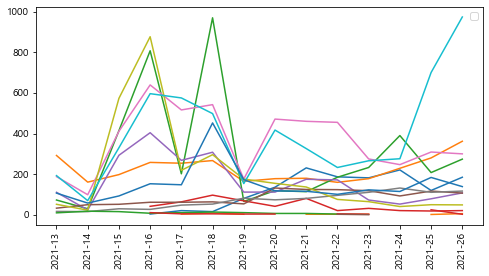

In [32]:
mpl.rc('figure', figsize=(8,4))
plt.plot(df3_count.T[-16:-2])
# lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fancybox=True, shadow=True, ncol=1,fontsize='large')
plt.xticks(rotation=90)
plt.legend()
plt.show()

No handles with labels found to put in legend.


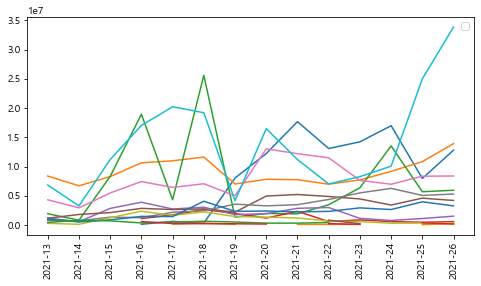

In [33]:
mpl.rc('figure', figsize=(8,4))
plt.plot(df3_amount.T[-16:-2])
# lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fancybox=True, shadow=True, ncol=1,fontsize='large')
plt.xticks(rotation=90)
plt.legend()
plt.show()